In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import argparse
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import math
from os import listdir
from os.path import join


In [12]:
from torchvision import transforms
import pickle
import nltk
from pycocotools.coco import COCO

In [24]:
crop_size=250
vocab_path='./Dataset_coco/vocab.pkl'
MAX_LENGTH = 57

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Reading & Resizing Coco Dataset

In [15]:
# TRAIN_PATH = Path("../Dataset_coco/train2014")
# TRAIN_OUTPATH = Path("../Dataset_coco/n_train2014")

# VAL_PATH = Path("../Dataset_coco/val2014")
# CAPTION_PATH = '../Dataset_coco/annotations/captions_train2014.json'

TRAIN_PATH = Path("./Dataset_coco/train2014")
TRAIN_OUTPATH = Path("./Dataset_coco/n_train2014")

VAL_PATH = Path("./Dataset_coco/val2014")
CAPTION_PATH = './Dataset_coco/annotations/captions_train2014.json'


In [7]:
len(list(TRAIN_PATH.iterdir()))

82783

In [62]:
! ls ../Dataset_coco/n_train2014 | head

In [8]:
def read_image(path):
    im = mpimg.imread(path) 
    return im

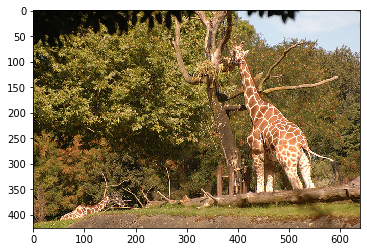

In [9]:
path = TRAIN_PATH/"COCO_train2014_000000000025.jpg"
im = read_image(path)
plt.imshow(im)

In [10]:
im.shape  # R,G,B

(426, 640, 3)

In [23]:
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def center_crop_square(im):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def get_a_crop(path, sz=250):
    im = cv2.imread(str(path))
    return cv2.resize(im, (sz, sz))
#     return cv2.resize(center_crop_square(im), (sz, sz))

def resize_all_images(input_path, output_path):
    
    input_path_str = str(input_path)
    for i,f in enumerate(os.listdir(input_path_str)):
       
        if f=='.DS_Store': continue
        
        img = get_a_crop(input_path_str+"/"+f)
        out_path_str = str(output_path) + "/"+f

        cv2.imwrite(out_path_str, img)
        
        if i%10000==0:
            print(f"Processed {i} images")
            print(out_path_str)


In [67]:
#resize_all_images(TRAIN_PATH, TRAIN_OUTPATH)

Processed 0 images
../Dataset_coco/n_train2014/COCO_train2014_000000223373.jpg
Processed 10000 images
../Dataset_coco/n_train2014/COCO_train2014_000000101632.jpg
Processed 20000 images
../Dataset_coco/n_train2014/COCO_train2014_000000124477.jpg
Processed 30000 images
../Dataset_coco/n_train2014/COCO_train2014_000000004259.jpg
Processed 40000 images
../Dataset_coco/n_train2014/COCO_train2014_000000527711.jpg
Processed 50000 images
../Dataset_coco/n_train2014/COCO_train2014_000000018916.jpg
Processed 60000 images
../Dataset_coco/n_train2014/COCO_train2014_000000180220.jpg
Processed 70000 images
../Dataset_coco/n_train2014/COCO_train2014_000000097936.jpg
Processed 80000 images
../Dataset_coco/n_train2014/COCO_train2014_000000068701.jpg


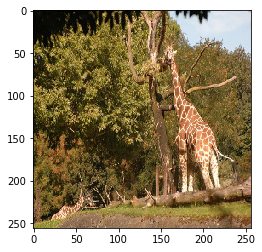

In [69]:
# Testing
path = TRAIN_OUTPATH/"COCO_train2014_000000000025.jpg"
im = read_image(path)
plt.imshow(im)

In [70]:
im.shape

(256, 256, 3)

## Creating Dataloaders

In [29]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [119]:
transform = transforms.Compose([ 
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

transform2 = transforms.Compose([ 
    transforms.RandomCrop(crop_size),
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

In [31]:
# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [165]:
class CocoDataset(Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None, N=MAX_LENGTH, padding_start=True):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        #Slicing a small dataset
        self.ids = list(self.coco.anns.keys())[:200]
        self.vocab = vocab
        self.transform = transform
        self.N = N + 2
        self.padding_start = padding_start

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        
        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        enc = np.zeros(self.N, dtype=np.int32)
        enc1 = np.array(caption)
        l = min(self.N, len(enc1))
        if self.padding_start:
            enc[:l] = enc1[:l]
        else:
            enc[self.N-l:] = enc1[:l]        

        target = torch.Tensor(enc)
        return image, target

    def __len__(self):
        return len(self.ids)

In [166]:
train_ds = CocoDataset(TRAIN_OUTPATH,CAPTION_PATH,vocab,transform, MAX_LENGTH, padding_start=True )

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


In [167]:
valid_ds = CocoDataset(TRAIN_OUTPATH,CAPTION_PATH,vocab,transform2, N=MAX_LENGTH, padding_start=True )

loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


In [37]:
# max_len=0
# for i in range(n):
#     lenTensor=len(train_ds[i][1])
#     if lenTensor>max_len:
#         max_len=lenTensor
#     if i%10000==0:
#         print(i)
    

In [173]:
batch_size=10
train_dl = DataLoader(dataset=train_ds,batch_size=batch_size,shuffle=True,num_workers=4)
valid_dl = DataLoader(dataset=valid_ds,batch_size=batch_size,num_workers=4)

In [174]:
img, caption = next(iter(train_dl))

In [175]:
img.shape, caption.shape

(torch.Size([10, 3, 250, 250]), torch.Size([10, 59]))

In [176]:
img, caption = next(iter(valid_dl))

In [178]:
img.shape, caption.shape

(torch.Size([10, 3, 250, 250]), torch.Size([10, 59]))

### BLEU Evaluation

Reference for BLEU-evaluation from NLTK (https://machinelearningmastery.com/calculate-bleu-score-for-text-python/)

In [265]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu

In [279]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test'], ['this', 'is', 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
print(score)


1.0


In [280]:
from nltk.translate.bleu_score import corpus_bleu
references = [ [['this', 'is', 'a', 'quiz'], ['this', 'is', 'test']]] #or hypothesis
candidates = [['this', 'is', 'a', 'test']]
print("BLEU-1 score", corpus_bleu(references, candidates,weights=(1, 0, 0, 0)))
print("BLEU-2 score", corpus_bleu(references, candidates,weights=(0, 1, 0, 0)))
print("BLEU-3 score", corpus_bleu(references, candidates,weights=(0, 0, 1, 0)))
print("BLEU-4 score", corpus_bleu(references, candidates,weights=(0, 0, 0, 1)))

BLEU-1 score 1.0
BLEU-2 score 0.6666666666666666
BLEU-3 score 0.5
BLEU-4 score 2.2250738585072626e-308


## Model 

In [43]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

class DecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(DecoderRNN, self).__init__()

        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=0)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        output, hidden = self.gru(embedded, hidden)
        output = self.out(hidden[-1])
        return output, hidden    

In [253]:
def train_batch(x, y, encoder, decoder, encoder_optimizer, decoder_optimizer,
                teacher_forcing_ratio=0.5):

    encoder.train()
    decoder.train()    
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    batch_size = y.size(0)
    target_length = y.size(1)
    
    enc_hidden = encoder(x) 
    enc_hidden = enc_hidden.unsqueeze(0) # adding one dimension 
    
    loss = 0
    dec_input = y[:,0].unsqueeze(1) # allways SOS
    hidden = enc_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(1, target_length):
        output, hidden = decoder(dec_input, hidden)
        yi =  y[:, di]
        if (yi>0).sum() > 0:
            # ignoring padding
            #print("outputs",output,yi)
            loss += F.cross_entropy(output, yi, ignore_index = 0, reduction="sum")/(yi>0).sum()
        if use_teacher_forcing:
            dec_input = y[:, di].unsqueeze(1)  # Teacher forcing: Feed the target as the next input
        else:                
            dec_input = output.argmax(dim=1).unsqueeze(1).detach()

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()

In [293]:
def valid_batch(x, y, encoder, decoder, max_length=MAX_LENGTH+2):
    
    decoder = decoder.eval()
    encoder = encoder.eval()
    loss = 0
    bleu4=0
    with torch.no_grad():  
        
        batch_size = x.size(0)

        hidden = encoder(x) 
        hidden = hidden.unsqueeze(0) # adding one dimension 

        dec_input = SOS_token*torch.ones(batch_size, 1).long() #.cuda()  # SOS
        decoded_words = []
        for di in range(1, max_length):
            output, hidden = decoder(dec_input, hidden)
            pred = output.argmax(dim=1)
            #predicted tokens (not sentence)
            decoded_words.append(pred.numpy()) #(pred.cpu().numpy())
            dec_input = output.argmax(dim=1).unsqueeze(1).detach()
            yi =  y[:, di]

            if (yi>0).sum() > 0:
                # ignoring padding
                loss += F.cross_entropy(
                    output, yi, ignore_index = 0, reduction="sum")/(yi>0).sum()
        
        
        return loss.item(), np.transpose(decoded_words)

In [287]:
def computing_BLEU(decoded_words , target):
    """
    # Decision based on BLEU-n
        # To-do
        # reference: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/blob/master/train.py
        
    """
    bleu_score = 0
    
    
    return bleu_score

In [299]:
def train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 10,
          teacher_forcing_ratio=0.5):
    
    best_bleu4 = 0 
    predicted_captions_val = []
    for i in range(epochs):
        
        print(f'epoch {i}')
        total_loss = 0
        total_loss_valid = 0
        loss_valid = 0
        total = 0
        total_valid = 0
#         encoder.train()
#         decoder.train()
        
        # One epoch training 
        for x, y in train_dl:
            x = x.float() #.cuda()
            y = y.long() #.cuda()
            
            loss = train_batch(x, y, encoder, decoder, enc_optimizer, dec_optimizer,
                               teacher_forcing_ratio)
            total_loss = loss*x.size(0)
            total += x.size(0)
            
        # One epoch validation
        list_decoded_words = []
        for x, y in valid_dl:  
            x = x.float() #.cuda()
            y = y.long() #.cuda()
            
            loss_valid, decoded_words  = valid_batch(x, y, encoder, decoder)
            total_loss_valid += loss_valid*x.size(0)
            total_valid += x.size(0)
            list_decoded_words.append(decoded_words) 
            
        bleu4 = 0 #computing_BLEU(decoded_words, y)
        
        if bleu4 >= best_bleu4:
            best_bleu4 = bleu4
            predicted_captions_val = list_decoded_words
            #save pytorch model 

        if i%1 == 0:
            print("train loss %.3f valid loss %.3f bleu-4 %.3f" % (total_loss / total, 
                                                                   total_loss_valid / total_valid,
                                                                   best_bleu4
                                                                  ))   
    return best_bleu4, predicted_captions_val

In [295]:
output_size = len(vocab)
hidden_size = 10  #embedding size of the img

encoder = EncoderCNN(hidden_size) #.cuda()
decoder = DecoderRNN(output_size, hidden_size) #.cuda()
enc_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
dec_optimizer = optim.Adam(decoder.parameters(), lr=0.001) 

In [296]:
batch_size=100
train_dl = DataLoader(dataset=train_ds,batch_size=batch_size,shuffle=True,num_workers=4)
valid_dl = DataLoader(dataset=valid_ds,batch_size=batch_size,num_workers=4)

In [297]:
len(train_ds)

200

In [298]:
best_bleu4, predicted_captions_val = train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 4)

epoch 0
train loss 83.452 valid loss 190.424 bleu-4 0.000
epoch 1
train loss 106.363 valid loss 189.969 bleu-4 0.000
epoch 2
train loss 106.529 valid loss 189.796 bleu-4 0.000
epoch 3
train loss 83.288 valid loss 189.623 bleu-4 0.000


In [302]:
np.array(predicted_captions_val).shape

(2, 100, 58)

## Evaluating the model (drafts only, we will delete it later)

In [245]:
def decoding(x, y, encoder, decoder, max_length=MAX_LENGTH+2):
    decoder = decoder.eval()
    encoder = encoder.eval()
    loss = 0
    with torch.no_grad():   
        batch_size = x.size(0)
        
        #enc_outputs, hidden = encoder(x)
        hidden = encoder(x) 
        hidden = hidden.unsqueeze(0) # adding one dimension 
      
        dec_input = SOS_token*torch.ones(batch_size, 1).long() #.cuda()  # SOS
        decoded_words = []
        
        for di in range(1, max_length):
            output, hidden = decoder(dec_input, hidden)
            pred = output.argmax(dim=1)
            decoded_words.append(pred.numpy()) #(pred.cpu().numpy())
            dec_input = output.argmax(dim=1).unsqueeze(1).detach()
            yi =  y[:, di]
            
            if (yi>0).sum() > 0:
                # ignoring padding
                loss += F.cross_entropy(
                    output, yi, ignore_index = 0, reduction="sum")/(yi>0).sum()
        return loss.item()/batch_size, np.transpose(decoded_words)

In [246]:
#MAX_LENGTH #without SOS and END tokens
SOS_token = 1
EOS_token = 2

batch_size=10
valid_dl= DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

x, y = next(iter(valid_dl)) 
x = x.float() #.cuda()
y = y.long() #.cuda()

loss, decoded_words = decoding(x, y, encoder, decoder)
loss

10.17541961669922

In [247]:
#predicted captions
decoded_words.shape

(10, 58)

In [252]:
xi = decoded_words[4]
print(' '.join([vocab.idx2word[t] for t in xi ]))

angel particular <end> bumper catch catch catch catch bumper catch catch rally <end> bathroom bathroom bathroom person <end> bathroom bathroom person <end> bathroom bathroom person <end> bathroom bathroom bathroom person <end> bathroom bathroom bathroom person <end> bathroom bathroom bathroom person <end> bathroom bathroom bathroom person <end> bathroom bathroom bathroom person <end> bathroom bathroom bathroom person <end> bathroom bathroom


In [207]:
xi.shape

(58,)

In [215]:
#COCO(CAPTION_PATH).anns.keys()
#48, 67, 126, 148, 173,
COCO(CAPTION_PATH).anns[173]

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


{'image_id': 379340,
 'id': 173,
 'caption': 'A graffiti-ed stop sign across the street from a red car '}